Project Phase III: Chess Prediction Model 

By Sandeep Salwan, Quangvinh Tran, and Andrew Fielding

# Preliminaries #

### Data loading and cleaning: ###

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [3]:
# load data
data = pd.read_csv('lichess_games_data.csv')
data.dropna(inplace=True)

In [4]:
# clean up the opening column so it only includes the broad category of opening (not variations)
data['opening_name'] = data['opening'].str.split(":").str[0].str.strip()

In [5]:
# drop original opening column
data = data.drop(columns = ['opening'])

In [6]:
# preliminary exploration of the data: 

print(f"The shape of the data is: {data.shape}")

data.head()

The shape of the data is: (163145, 9)


,game_id,white,white_rating,black,black_rating,winner,moves,link,opening_name
0,hN05at52,aapp_61,1678.0,zwenna,2442.0,black,54,https://lichess.org/hN05at52,Sicilian Defense
1,ttu4bd63,zwenna,2437.0,Aidas08,2136.0,white,77,https://lichess.org/ttu4bd63,Sicilian Defense
2,Qwoly8kd,Ugjgjgjvj,2058.0,zwenna,2434.0,black,44,https://lichess.org/Qwoly8kd,Italian Game
3,eMJwQKDV,zwenna,2433.0,Narcisse29,1820.0,white,21,https://lichess.org/eMJwQKDV,French Defense
4,8AFBBfka,zwenna,2433.0,Bracho2013,1089.0,white,57,https://lichess.org/8AFBBfka,Ruy Lopez


### Helper function construction: ###

In [79]:
# helper functions to translate the string "winner" feature (eg white, black, draw) into floats (eg 1, 0, 0.5)
def encode_winner(player_color, winner):
    if winner == player_color:
        return 1
    elif winner == 'draw':
        return 0.5
    return 0

def encode_winner_simple(winner):
    if winner == 'white':
        return 1
    if winner == 'black':
        return 0
    return 0.5

# helper function to add a bias column (for OLS) to an array of X features
def add_bias_column(X):
    """
    Args:
        X (array): can be either 1-d or 2-d
    
    Returns:
        Xnew (array): the same array, but 2-d  with a column of 1's in the first spot
    """
    
    # If the array is 1-d
    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])
    
    # If the array is 2-d
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])
        
    else:
        raise ValueError("Input array must be either 1-d or 2-d")

    return Xnew

# helper function to calculate the coefficients for the line of best fit given arrays of dependent and independent variables
def line_of_best_fit(X, y):
    """ calculates the coefficients for the line of best fit for a set of data
    Args:
        X (array): can be either 1-d or 2-d
        y (array): 1-d array including all corresponding response values to X
        
    Returns:
        m (vector): contains coefficients for line of best fit 
    """
    #add the bias column to X
    Xnew = add_bias_column(X)
        
    # Inverse of Xnew.transpose * Xnew
    XtXinv = np.linalg.inv(np.matmul(Xnew.T, Xnew))
    
    # Xnew.transpose * y 
    Xty = np.matmul(Xnew.T, y)
    
    # [(XtX)^-1]Xty to get the vector w/ coefficients for line of best fit
    # m = [intercept, slope]
    m = np.matmul(XtXinv, Xty)
    return m

# helper function to calculate the results of a linear regression model--eg y predictions, residuals, MSE, and R^2
def linreg_predict(Xnew, ynew, m):
    """ calculates the predicted y values using the coefficients of the line of best fit for the data.
    calculates the residuals, mse, and r^2 between the predicted and actual y values.
    Args:
        Xnew (array): an array, either 1-d or 2-d which includes all the predictor features, 
        not including bias term
        ynew (array): a 1-d array which includes all corresponding response values to Xnew
        m (vector): a 1-d array of length p+1 which contains the coefficients from the 
        line_of_best_fit function
        
    Returns:
        linreg_dict (dictionary): dictionary containing key value pairs: ypreds, resids, mse, r2
    """
    Xnew = add_bias_column(Xnew)
    
    #calculating the predicted y values using the coefficients from line_of_best_fit
    ypreds = np.matmul(Xnew, m)

    #calculating residuals
    resids = ynew - ypreds

    #calculating mean square error (mse)
    sum_resids = 0
    for item in resids:
        sum_resids += item**2  
    mse = sum_resids/len(resids)

    #calculating r^2 value
    r2 = r2_score(ynew, ypreds)
    
    # Creating dictionary
    linreg_dict = {'ypreds' : ypreds,
                   'resids' : resids,
                   'mse' : mse,
                   'r2' : r2}
    return linreg_dict

In [80]:
#cross validation function using train_test_split from sklearn
def cross_validation(X, y, train, rand_state=None):
    ''' Performs single-fold cross-validation on given set of data for a given train_size (trn_size)
    Args:
    X (array)- an array, either 1-d or 2-d which includes all the predictor features, not including bias term1D array
    y (array)- a 1-d array which includes all corresponding response values to X
    train (float)- decimal ranging from 0.1 to 1.0
    rand_state (int)- integer value
    
    Return:
    linreg_dict (dictionary)- dictionary containing predicted array of y values (ypreds), 
                        array of residual (resids), mean square error (mse), and r^2 (r2)
    m (vector): contains coefficients for line of best fit 
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= train, random_state = rand_state)

    #calculating coefficients for line of best fit
    m = line_of_best_fit(X_train, y_train)
    
    #running predictions and calculating MSE and R^2
    linreg_dict = linreg_predict(X_test, y_test, m)

    return linreg_dict,m,y_test

def full_linreg(X, y):
    ''' fits full dataset to linear regression model.
    Args:
    X (array)- array of varying dimension size
    y (array)- 1-d array which includes all corresponding response values to Xnew

    Returns:
    mse (float)- mean square error
    r2 (float)- r^2 value
    resids (array)- 1-d array of residual values between actual and predicted y values
    '''
    #calculating coefficients to line of best fit for the full model
    m_full = line_of_best_fit(X, y)
    
    #running predictions for the full model
    linreg_dict = linreg_predict(X, y, m_full)
    ypred = linreg_dict['ypreds']
    mse = linreg_dict["mse"]
    r2 = linreg_dict['r2']
    resids = linreg_dict['resids']
    
    return mse, r2, resids, m_full, ypred

# First Regression Model: Linear Regression #

Our two primary areas of interest for the project are trying to predict the outcome of a game (eg whether white or black will win) and to predict how many moves it will take for the game to be completed. We decided to start with trying to model the winner of the game. Our first idea was to create a linear regression model that would use the rating differential between the two players playing the game (eg the white player's Lichess rating less the black player's Lichess rating) to predict the win outcome of the game. However, since win outcome is a categorical variable and linear regression is primarily useful to predict numerical features, we workshopped a different approach. 

We thought that one way to get an idea of a prediction would be to predict the win rate (rather than the win outcome) for a player based on the rating differential. We decided to bin the data by rating differential, so if the rating differential between two players in a game fell into the bucket of, for instance, 225 (eg perhaps white had a rating of 2225 and black had a rating of 2000) it would fall into the 200-250 bucket. We then calculated the win rate for white for each bucket. For example, in the 200-250 bucket, the white player wins about 77% of the time. This data manipulation yielded a new dataframe with about 40 observations (rating differential bins) that each had a given win rate. We then proceeded to fit a linear regression model to the new data, predicting win rate based on median rating differential. 

### Step 1: data manipulation ###

In [81]:
# prep data simply
white_data = data.copy()
white_data['player_rating'] = white_data['white_rating']
white_data['opponent_rating'] = white_data['black_rating']
white_data['win_outcome'] = white_data.apply(lambda row: encode_winner('white', row['winner']), axis=1)
black_data = data.copy()
black_data['player_rating'] = black_data['black_rating']
black_data['opponent_rating'] = black_data['white_rating']
black_data['win_outcome'] = black_data.apply(lambda row: encode_winner('black', row['winner']), axis=1)

#combine+ filter draws
combined_data = pd.concat([white_data, black_data])
combined_data = combined_data[combined_data['win_outcome'] != 0.5]

# bin ratings and group
bins = np.arange(800, 2800, 100)
labels = bins[:-1] + 50
combined_data['player_rating_bin'] = pd.cut(combined_data['player_rating'], bins, labels=labels)
combined_data['opponent_rating_bin'] = pd.cut(combined_data['opponent_rating'], bins, labels=labels)

# pivot for the win percentages
win_table = combined_data.pivot_table('win_outcome', index='player_rating_bin', columns='opponent_rating_bin', aggfunc='mean', observed = False) * 100

# adding rating differential and win outcome as columns to the original dataframe (for use later as needed)
data['rating_diff'] = data['white_rating'] - data['black_rating']
data['win_outcome'] = data['winner'].apply(encode_winner_simple)

# win % grouped by diff bins
bins = np.arange(-1000, 1000, 50)
data['rating_diff_bin'] = pd.cut(data['rating_diff'], bins)
win_percentage = data.groupby('rating_diff_bin', observed=True)['win_outcome'].mean().reset_index()

# midpoints (grouping the categories of ratings)
win_percentage['rating_diff_mid'] = win_percentage['rating_diff_bin'].apply(lambda x: x.mid)

In [82]:
# prints the win rate/rating differential dataframe for examination
win_percentage

,rating_diff_bin,win_outcome,rating_diff_mid
0,"(-1000, -950]",0.129518,-975.0
1,"(-950, -900]",0.116071,-925.0
2,"(-900, -850]",0.098826,-875.0
3,"(-850, -800]",0.102024,-825.0
4,"(-800, -750]",0.152113,-775.0
5,"(-750, -700]",0.127273,-725.0
6,"(-700, -650]",0.125668,-675.0
7,"(-650, -600]",0.136850,-625.0
8,"(-600, -550]",0.217405,-575.0
9,"(-550, -500]",0.183839,-525.0


### Step 2: Implement the linear regression programmatically using maths/Numpy ###

In [83]:
X = win_percentage['rating_diff_mid'].values
y = win_percentage['win_outcome'].values
X_b = np.c_[np.ones((len(X), 1)), X]
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
y_pred = X_b @ theta_best

### Step 3: Build some visualizations to explore the initial data (heatmap) and see how the regression model looks (scatter/line plot) ###

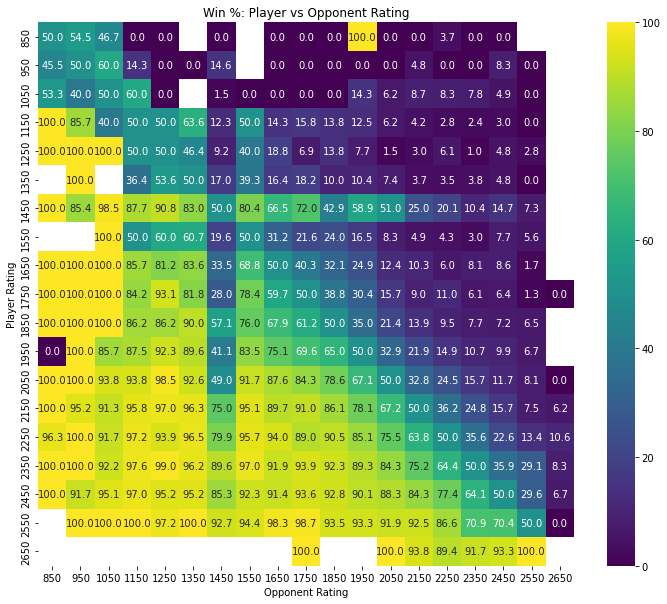

In [84]:
# heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(win_table, annot=True, fmt=".1f", cmap='viridis')
plt.title('Win %: Player vs Opponent Rating')
plt.xlabel('Opponent Rating')
plt.ylabel('Player Rating')
plt.show()

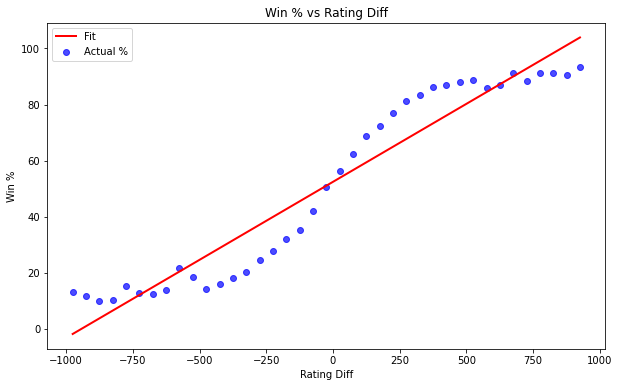

In [85]:
# plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(X, y * 100, color='blue', alpha=0.7, label='Actual %')  # data points
plt.plot(X, y_pred * 100, color='red', linewidth=2, label='Fit')  #our regression line
plt.title('Win % vs Rating Diff')
plt.xlabel('Rating Diff')
plt.ylabel('Win %')
plt.legend()
plt.show()

#### Discussion: ####
It is clear from the initial visualization that there is indeed a pattern to the data. There is significant curvature to the dots that represent each rating differential point and its associated win rate. The line of best fit seems to travel fairly accurately through the middle-ish points of the curved line created by the scatter points. However, this shape suggests that perhaps a linear regression model is not the best way to make predictions on this data, but we will persist and calculate the results of the initial model anyway. 

### Step 4: Single-fold 70/30 cross-validated results 

In [86]:
cross_val = cross_validation(X, y, 0.7, 3)
cross_val
mse = cross_val[0]["mse"]
r2 = cross_val[0]['r2']
print(f'MSE: {mse}')
print(f'R^2: {r2}')

MSE: 0.010595315600734302
R^2: 0.8822509664418586


### Step 5: Calculate the results of the full dataset model ###

In [87]:
full_fit = full_linreg(X, y)
full_fit
mse = full_fit[0]
r2 = full_fit[1]
resids = full_fit[2]
print(f'MSE: {mse}')
print(f'R^2: {r2}')

MSE: 0.008153554912551328
R^2: 0.923279666609376


#### Discussion: #### 
The R^2 score and MSE for the full data set are 0.923 and 0.0082, respectively. This suggests the data is very linear and the model is highly accurate and that the rating differential can explain approximately 92% of the variation in the win rate for the white player. It must be noted that the shape of the data suggests a non-linear (1 dimensional) pattern so the linear regression model may not be the best model to use despite the MSE and R^2 values.

### Step 6: Create residual plots to test assumptions ###

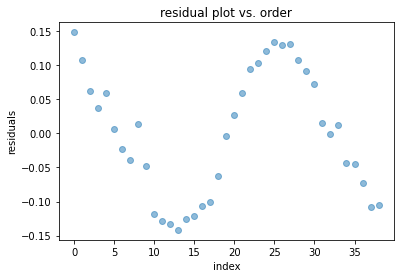

In [88]:
# residuals versus order (ordered e plot)
plt.scatter(range(len(X_b)), resids, alpha=0.5)
plt.xlabel("index")
plt.ylabel("residuals")
plt.title("residual plot vs. order")
plt.show()

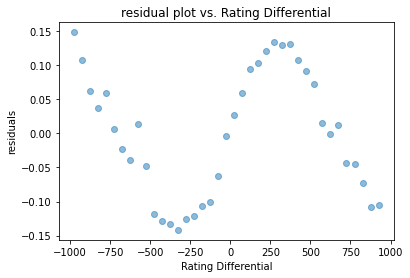

In [89]:
#residual plot vs x feature (rating diff)
plt.scatter(X, resids, alpha=0.5)
plt.xlabel("Rating Differential")
plt.ylabel("residuals")
plt.title("residual plot vs. Rating Differential")
plt.show()

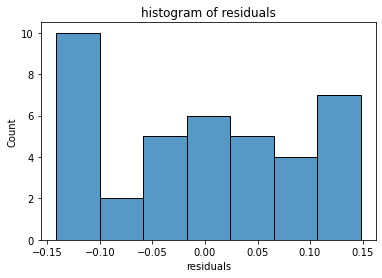

In [90]:
# histogram of residuals
sns.histplot(resids, kde=False)
plt.xlabel("residuals")
plt.title("histogram of residuals")
plt.show()

### Step 7: Discussion and reflections ###

Residual plots of the linear regression suggest we may need to look at trinomial or another variable since there are clear patterns. The residual plot as a function of the index shows an oscillating pattern indicating autocorrelation. The residual plot as a function of rating differential also shows the oscillating pattern indicating a non-linear dataset and heteroscedasticity. A normal distribution of the residuals is not present. It is clear from the histogram of residuals that there is a concentration of residuals on the tails of the distribution, which does not align with the shape of the normal distribution. Despite the strong performance of the model (a cross-validated R^2 score of nearly a 0.9 is quite impressive for a linear regression model), it seems clear that there are significant issues with the model in its current state. The obvious violations of critical assumptions based on the residual plots are enough to tell us that the model is, at present, not particularly useful for actual prediction, despite its strong results. Based on the pattern we are seeing in the residual plots, it seems likely that a non-linear model would improve on the current iteration by (potentially) weeding out some of the issues with assumptions that we see here. If we think empirically/intuitively, this also makes more sense based on the shape of the data that we saw in the original scatterplot with the line of best fit. It was clear from that plot that the data followed an oscillating shape, perhaps being most similar to a polynomial of 3rd degree. As a result, we decided to implement polynomial regression. Our starting point to address these issues was a 3rd degree polynomial regression.

# Second Regression Model: Polynomial Regression #

### Step 1: Build the (3rd degree) polynomial features for the rating differential variable: ###

In [91]:
from sklearn.preprocessing import PolynomialFeatures

# utilize sklearn PolynomialFeatures and .fit_transform to manipulate the data
poly = PolynomialFeatures(3, include_bias = False)
X_poly = poly.fit_transform(np.array(X).reshape(-1,1))

### Step 2: Single-fold 70/30 cross validated results: ###

In [92]:
poly_cross_val = cross_validation(X_poly, y, 0.7, 3)

poly_mse = poly_cross_val[0]["mse"]
poly_r2 = poly_cross_val[0]['r2']
print(f'MSE: {poly_mse}')
print(f'R^2: {poly_r2}')

MSE: 0.002619568988752862
R^2: 0.9708879160953781


### Step 3: Fit the model to the full set of 3rd degree data for rating diff: ###

In [93]:
poly_full_fit = full_linreg(X_poly, y)
full_fit
poly_full_mse = poly_full_fit[0]
poly_full_r2 = poly_full_fit[1]
poly_full_resids = poly_full_fit[2]
print(f'MSE: {poly_full_mse}')
print(f'R^2: {poly_full_r2}')

MSE: 0.0018396405428681413
R^2: 0.9826900245007869


#### Discussion: ####

The 3rd degree polynomial regression was an improvement on the initial linear regression model in terms of the R^2 score. The R^2 score of 0.983, suggests that the model explains about 98% of the variation in the win rate for some rating differential. If the residual plots show improvements in the issues with assumptions, this model is a very strong candidate. 

### Step 4: Create residual plots to check assumptions ###

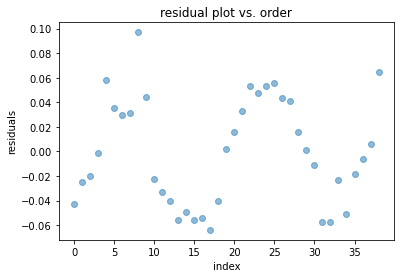

In [94]:
# residuals versus order
plt.scatter(range(len(X_poly)), poly_full_resids, alpha=0.5)
plt.xlabel("index")
plt.ylabel("residuals")
plt.title("residual plot vs. order")
plt.show()

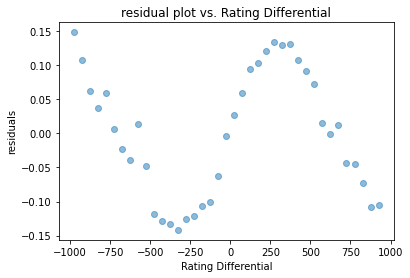

In [95]:
#residual plot vs Rating Diff
plt.scatter(X, resids, alpha=0.5)
plt.xlabel("Rating Differential")
plt.ylabel("residuals")
plt.title("residual plot vs. Rating Differential")
plt.show()

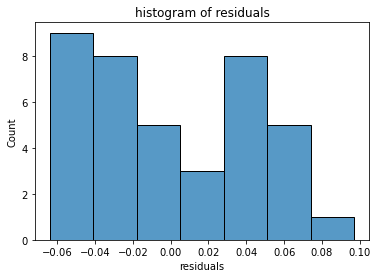

In [96]:
# histogram of residuals
sns.histplot(poly_full_resids, kde=False)
plt.xlabel("residuals")
plt.title("histogram of residuals")
plt.show()

### Step 5: Discussion ###
Despite an improved (and exceptionally strong) R^2 score, on both a general and cross-validated basis, it is clear from the residual plots that the same issues with assumptions persist in this 3rd degree polynomial variation of the model. There are evidently still issues with linearity/homoscedasticity, autocorrelation, and normality. However, it does seem as though the graphs are at least somewhat more random than they were in the simple linear regression model. Going back to the original scatterplot of the data with the line of best fit, it seems possible (or, at least, reasonable) that the data may actually best fit an even higher order model. Therefore, we decided to fit the model again with a 6th degree polynomial to see if we could improve on any of the assumptions further. Anything higher seems likely to put the model at risk of overfitting (and indeed, even a 6th degree may be overfit) given that the manipulated win rate/rating differential dataset has only about 40 observations. Whenever the number of features gets high relative to the number of observations, the model's usefulness is put in doubt. 

### Step 6: Refit and cross validate the model with a 6th degree polynomial ###

In [97]:
# utilize sklearn PolynomialFeatures and .fit_transform to manipulate the data
poly = PolynomialFeatures(6, include_bias = False)
X_poly = poly.fit_transform(np.array(X).reshape(-1,1))

#### Cross validation

In [98]:
poly_cross_val = cross_validation(X_poly, y, 0.7, 3)

poly_mse = poly_cross_val[0]["mse"]
poly_r2 = poly_cross_val[0]['r2']
print(f'Cross-validate MSE: {poly_mse}')
print(f'Cross-validate R^2: {poly_r2}')

Cross-validate MSE: 0.0010409942754861148
Cross-validate R^2: 0.9884311072461539


#### Full Data

In [99]:
poly_full_fit = full_linreg(X_poly, y)
full_fit
poly_full_mse = poly_full_fit[0]
poly_full_r2 = poly_full_fit[1]
poly_full_resids = poly_full_fit[2]
print(f'Full model MSE: {poly_full_mse}')
print(f'Full model R^2: {poly_full_r2}')

Full model MSE: 0.0005733397223464467
Full model R^2: 0.9946051979637992


### Step 7: Create residual plots for 6th order polynomial regression ###

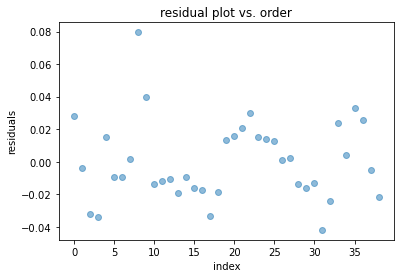

In [100]:
# residuals versus order
plt.scatter(range(len(X_poly)), poly_full_resids, alpha=0.5)
plt.xlabel("index")
plt.ylabel("residuals")
plt.title("residual plot vs. order")
plt.show()

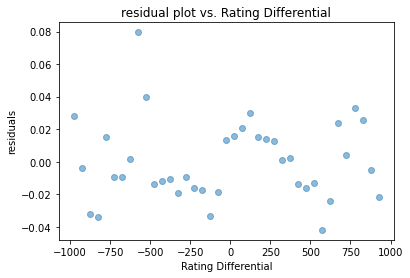

In [101]:
#residual plot vs Rating Diff
len(X)
plt.scatter(X, poly_full_resids, alpha=0.5)
plt.xlabel("Rating Differential")
plt.ylabel("residuals")
plt.title("residual plot vs. Rating Differential")
plt.show()

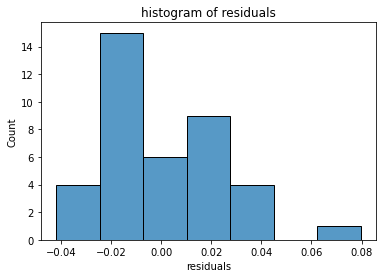

In [102]:
# histogram of residuals
sns.histplot(poly_full_resids, kde=False)
plt.xlabel("residuals")
plt.title("histogram of residuals")
plt.show()

### Step 8: Final discussion and reflections ###
The sixth order polynomial function seems to be the best regression model for predicting the win rate based on the rating differential bin of a given game, the objective we laid out at the beginning of the creation of these two linear regression models. It achieves an R^2 score of just under 0.99 on a cross validated basis, suggesting extraordinary precision and strong predictive power. Additionally, the residual plots to check the model's assumptions appear to be best for the 6th degree polynomial, as compared to the 3rd degree and monomial linear regression using the same rating differential bucket feature to predict win rate. For the 6th degree polynomial, while there is still some visible oscillation in the ordered e plot and residuals versus x-feature plot, these two scatters are the most random distributions of points of any of the models we tried to make this prediction. This suggests that while there may still be some issues with the linearity, homoscedasticity, and lack of autocorrelation in the model, the validity of the assumptions has improved from the original models. Additionally, the histogram of residuals appears to be closest to a normally distributed histogram for this model. Again, the graph is not perfect--we can see that there are large spikes on either side of zero, and that the histogram may not be perfectly centered at zero. However, this model's histogram trails off into the tails as a normal distribution does, which neither of the previous models did. The ongoing presence of some issues, but their relative improvement, suggests that the while there may still be some issues with normality, it is more valid to assume normality for this model than for the previous ones. Overall, based on the magnitude of the R^2 score and the improved assumptions checks, it is clear this model is the best of the three proposed here for this particular prediction. 

However, we ultimately decided that this model may just not be the best or most useful one to predict a player's chance of victory based on the rating differential in a game. First and foremost, although we were apparently able to improve upon the validity of the assumptions from the original model (where they were extremely dubious), it is still fairly clear that these assumptions are likely not wholly valid in the 6th degree polynomial regression. Additionally, as we were thinking intuitively about the model, it occured to us that by binning the rating differentials and predicting the win rate using those bins, we probably built a model that wasn't actually that informative. Indeed, it would be best to predict the win PROBABILITY or win OUTCOME (rather than just how frequently a player actually wins the game) based on any given specific rating differential, not just based on the average win rate for a broad bucket of rating differentials. Win rate was convenient to predict with regression, since it is a numerical feature and you cannot use regression to predict a categorical feature. However, we thought it would be best and most useful to predict a specific outcome based on a specific game. We determined that this model is useful for getting a feel for the data empirically. It shows how frequently different types of games are won by each players broadly. But for the sake of specificity and increasing the usefulness of the model, we decided that we would need to implement a different model. Specifically, we planned to implement a perceptron model, which is more equipped to predict categorical features based on numerical inputs. A preliminary version of that model will be included below. 

# Third Regression Model #

Before implementing the preliminary perceptron model, we wanted to try to implement a more useful regression model. Another of our key questions for the project (besides predicting the win outcome of a game) was to try to understand how the opening the players engaged with, the ratings of the two players, and the win outcome impacted the number of moves it took to end the game. There are various benefits to building a model that can effectively predict the move count. First of all, it has applications for any chess enthusiasts who like to [gamble](https://www.sbo.net/chess/#:~:text=Chess%20betting%20has%20become%20increasingly,to%20bet%20on%20chess%20online.), an increasingly popular endeavor. Bettors who want to wager on the length of a game would find this model useful. Additionally, in conjunction with a more effective model for predicting win outcomes or win probabilities, understanding the predicted or expected move count could provide a valuable training tool for chess players to evaluate their performance. If a player expects to win a game based on our predictive algorithm, they can also predict how quickly they should win the game. That way, they can see if they were more, less, or about as efficient as they should have been if they ultimately win the game. Intuitively, it seems likely that there should be predictive power here. In our Phase II project, we saw that there were clear patterns in scatterplots of the rating differential of a game versus its length when sorted by opening type. Different openings are generally seen as more or less aggressive (and therefore lead to longer or shorter games), and it seems logical and likely that when there is a large skill gap between the players involved in a game, the game should be quick. You would think that a much better player would beat a much worse player quickly. By the same token, it would likely take longer for more evenly matched players to finish their games. In cases of upsets, it's more difficult to think about game length. However, it seems like there should be at least some relationship here. 

To implement this model, we needed to manipulate the data again to add dummy variables for all of the different openings in the dataset. The opening of a game is determined jointly by the two players based on the first move or the first few moves they collectively make. In our (very large) dataset, there are more than 100 unique openings. However, we decided to implement the model using all of them. Since the model will be trained to predict on the entire dataset of over 160,000 games, having that many features in the model seems fairly reasonable from an overfitting standpoint. We also needed to scale the features, as we wanted to include the raw ratings instead of the differential. We then fit the model using linear regression to see how well we could do. 

### Step 1: data manipulation ###

In [103]:
# build the dummy variable columns from the original dataframe, dropping the first for a reference variable
df = pd.get_dummies(data, columns = ['opening_name'], drop_first = True)
df = df.dropna()

# standardize the black ratings and white ratings
for feat in ['white_rating', 'black_rating']:
    df[f'{feat}_scaled'] = (df[feat] - df[feat].mean()) / df[feat].std()
    
# drop all the columns that aren't relevant (x features) to this regression
reg_df = df.drop(columns = ['game_id', 'white', 'white_rating', 'black', 'black_rating', 'winner', 'link', 'rating_diff', 'rating_diff_bin', 'moves'], axis = 1)

In [104]:
# print out the manipulated data's shape and the first few rows to get an idea of what it looks like
print(reg_df.shape)
reg_df.head()

(160973, 139)


,win_outcome,opening_name_Amar Opening,opening_name_Amazon Attack,opening_name_Anderssen's Opening,opening_name_Australian Defense,opening_name_Barnes Defense,opening_name_Barnes Opening,opening_name_Benko Gambit,opening_name_Benko Gambit Accepted,opening_name_Benko Gambit Declined,...,opening_name_Vienna Game,opening_name_Vulture Defense,opening_name_Wade Defense,opening_name_Ware Defense,opening_name_Ware Opening,opening_name_Yusupov-Rubinstein System,opening_name_Zukertort Defense,opening_name_Zukertort Opening,white_rating_scaled,black_rating_scaled
0,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-1.523599,1.470828
1,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.455647,0.275692
2,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.032013,1.439583
3,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.439947,-0.958500
5,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.075191,1.420054


In [105]:
# build the X and y arrays using the scaled x values and the y values from the original data
reg_df = reg_df.replace({False: 0, True: 1})
X = reg_df.values
# X = reg_df.values
y = df['moves'].values

### Step 2: Single-fold 70/30 cross validated results ###

In [106]:
multi_cross_val = cross_validation(X, y, 0.7, 3)

multi_mse = multi_cross_val[0]["mse"]
multi_r2 = multi_cross_val[0]['r2']
print(f'MSE: {multi_mse}')
print(f'R^2: {multi_r2}')

MSE: 1257.0877967999709
R^2: 0.05717537906404169


### Step 3: Implement the regression model on the entire dataset ###

In [107]:
multi_full_fit = full_linreg(X, y)

multi_full_mse = multi_full_fit[0]
multi_full_r2 = multi_full_fit[1]
multi_full_resids = multi_full_fit[2]
print(f'MSE: {multi_full_mse}')
print(f'R^2: {multi_full_r2}')

multi_full_fit[3]

MSE: 1260.9144761679697
R^2: 0.059853398013485326


array([ 7.64995429e+01, -3.12946063e+00,  6.39287955e+00,  1.18743894e+01,
        8.10942469e+00, -9.06197107e+00, -6.55585030e+00, -1.83182356e+01,
       -7.07894401e-01,  1.12004457e+00, -1.21827989e+01, -1.49857314e+00,
       -3.04733289e+00, -6.38558705e+00, -1.01238850e+01, -8.91040698e+00,
       -7.57367887e+00, -1.60695570e+01, -1.45393523e+01,  2.51756949e+00,
       -3.31859191e+01, -1.29018302e+01,  2.61630734e-01, -2.31587158e+00,
       -1.20758603e+01,  1.18394206e+00, -1.05447018e+01, -1.10487137e+01,
       -1.96387079e+01,  4.87006896e+00, -3.83995756e+00, -8.49854509e+00,
       -1.42087930e+01, -9.84011665e+00, -2.29637810e+01, -4.01853655e+00,
       -1.75628954e+01,  8.14121075e-02, -6.58649673e+00, -5.57187724e+00,
       -6.96691659e-01, -1.31289770e+01, -1.00665028e+01, -3.63049887e+00,
       -5.96641589e+00, -2.23860657e+00,  1.70968191e+01, -1.18601356e+00,
       -5.69807109e+00, -1.19882354e+01, -2.18309249e-01,  2.08514143e+01,
       -7.44278774e+00,  

### Step 4: Create residual plots to check assumptions ###

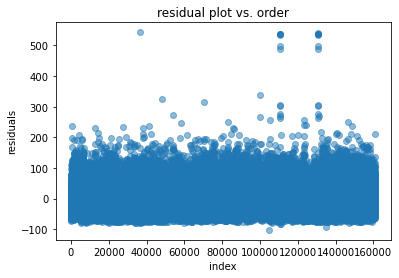

In [108]:
# residuals versus order
plt.scatter(range(len(X)), multi_full_resids, alpha=0.5)
plt.xlabel("index")
plt.ylabel("residuals")
plt.title("residual plot vs. order")
plt.show()

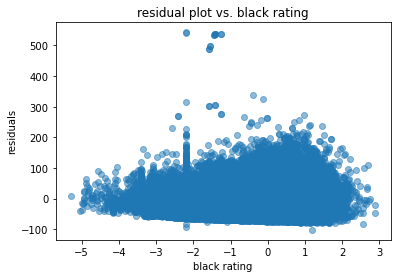

In [109]:
#residual plot vs black rating
plt.scatter(X[:, -1], multi_full_resids, alpha=0.5)
plt.xlabel("black rating")
plt.ylabel("residuals")
plt.title("residual plot vs. black rating")
plt.show()

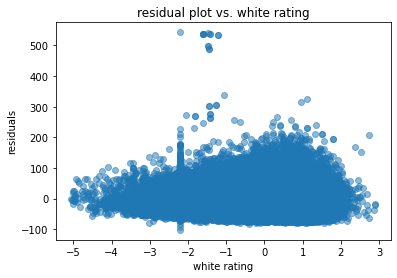

In [110]:
#residual plot vs white rating
plt.scatter(X[:, -2], multi_full_resids, alpha=0.5)
plt.xlabel("white rating")
plt.ylabel("residuals")
plt.title("residual plot vs. white rating")
plt.show()

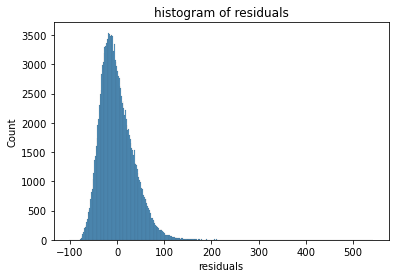

In [111]:
# histogram of residuals
sns.histplot(multi_full_resids, kde=False)
plt.xlabel("residuals")
plt.title("histogram of residuals")
plt.show()

### Step 5: Discussion ###
The preliminary model is very weak and does not model the data well. It achieves an R^2 score of about 0.06. This suggests that the model has very weak predictive power and only explains about 6% of the variation in the move count variable. Additionally, we are seeing some issues in observing the residual plots to check for assumptions. The ordered residual plot appears to be a mostly random distribution of points along the index. There is no obvious pattern in the plot, which suggests that the assumption of no autocorrelation that is critical for regression likely holds. However, it is possible that there are less noticeable underlying patterns that are difficult to pick up in the graph due to the volume of data (160,000). On the whole though, that assumption seems safe here. The normality assumption also seems fairly reasonable for this regression. The histogram of the residuals is certainly not perfectly normally distributed. We can see that the tail is longer to the right of the plot, suggesting some right skewness to the data. However, it approximately follows the bell curve we would expect for normality, and is centered near zero. Especially considering that normality is a less critical assumption, it is likely safe to say that the residuals are normal enough. However, the issues become clear when we observe the residual versus x features plots. The plots showing residuals versus the white rating and black rating features--our two numeric features for this regression--both show some level of funneling, with smaller x values corresponding to smaller residuals and larger x values corresponding to larger residuals. We can also see patterns in some of the plots of the categorical (dummy) x features versus the residuals. The plots that show openings versus residuals are harder to draw conclusions from, because most openings were played less frequently than not, so there were more 0 values than 1 values. However, there does seem to a fairly consistent trend towards lower residuals for 1 values than 0 values for most openings. Additionally, for the residual plot as a function of win outcome, while the residuals appear fairly consistent for 0 and 1 (loss and win) outcomes, 0.5 (draw) outcomes seem like they may have consistently higher residuals. These patterns suggest that there are some issues with linearity and homoscedasticity in the model. Thus, the model's usefulness is placed in doubt not just by its low R^2 score, but also by potential issues with critical assumptions. 

In speaking to Professor Gerber during office hours, we came to understand that there are some data manipulation steps we can take to try to ease some of the issues with assumptions. We hope to implement some of those changes and make the model's assumptions a little bit more robust for the final phase of the project. In the meantime, we tried a few different implementations to at least increase the model's R^2 score. We implemented the model with a smaller subset of the data (only including the top 10 most frequently used openings), tried using rating differential instead of the individual ratings, tried eliminating some features from the model, and tried creating polynomial features for the ratings. None of those steps yielded an improvement in the model, and some actually worsened its precision. One change we made that resulted in a small incremental improvement was to run the same model with an interaction term between the white rating and black rating. This implementation can be seen below. 

### Step 6: Implement with interaction term ###

In [112]:
reg_df['rating_interaction'] = reg_df.white_rating_scaled * reg_df.black_rating_scaled

reg_df.head()

,win_outcome,opening_name_Amar Opening,opening_name_Amazon Attack,opening_name_Anderssen's Opening,opening_name_Australian Defense,opening_name_Barnes Defense,opening_name_Barnes Opening,opening_name_Benko Gambit,opening_name_Benko Gambit Accepted,opening_name_Benko Gambit Declined,...,opening_name_Vulture Defense,opening_name_Wade Defense,opening_name_Ware Defense,opening_name_Ware Opening,opening_name_Yusupov-Rubinstein System,opening_name_Zukertort Defense,opening_name_Zukertort Opening,white_rating_scaled,black_rating_scaled,rating_interaction
0,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-1.523599,1.470828,-2.240952
1,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.455647,0.275692,0.401311
2,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-0.032013,1.439583,-0.046086
3,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.439947,-0.958500,-1.380189
5,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-0.075191,1.420054,-0.106775


In [113]:
# rebuild the X and y arrays using the x values from the updated reg_df and the y values from the original data
X = reg_df.values
y = df['moves'].values

### Step 7: Single-fold 70/30 cross validation ###

In [114]:
multi_cross_val = cross_validation(X, y, 0.7, 3)

multi_mse = multi_cross_val[0]["mse"]
multi_r2 = multi_cross_val[0]['r2']
print(f'MSE: {multi_mse}')
print(f'R^2: {multi_r2}')

MSE: 1247.827117668795
R^2: 0.06412095304359433


In [115]:
max_dummy_coef_idx = multi_cross_val[1][2:-3].argmax()
min_dummy_coef_idx = multi_cross_val[1][2:-3].argmin()

max_dummy_coef = reg_df.columns[max_dummy_coef_idx + 1]
min_dummy_coef = reg_df.columns[min_dummy_coef_idx + 1]

print(f'The opening with the largest and smallest coefficients are {max_dummy_coef} and {min_dummy_coef} respectively, with coefficients of {multi_cross_val[1][2:-3].max()} and {multi_cross_val[1][2:-3].min()}.')
print(f'The intercept is {multi_cross_val[1][0]}')
print(f'Other coefficients: win outcome is {multi_cross_val[1][1]}, white rating is {multi_cross_val[1][-3]}, black rating is {multi_cross_val[1][-2]}, and the rating interaction  is {multi_cross_val[1][-1]}')

The opening with the largest and smallest coefficients are opening_name_Guatemala Defense and opening_name_Zukertort Defense respectively, with coefficients of 62.604988246036555 and -56.05307918684275.
The intercept is 75.87664084585845
Other coefficients: win outcome is -3.3639454347128037, white rating is 4.1306507628162805, black rating is 5.260052370828639, and the rating interaction  is 2.6633716831998067


### Step 8: Fitting Full Data

In [116]:
full_fit = full_linreg(X, y)
full_mse = full_fit[0]
full_r2 = full_fit[1]
full_resids = full_fit[2]
print(f'MSE: {full_mse}')
print(f'R^2: {full_r2}')

MSE: 1250.2917217882698
R^2: 0.0677737975509336


### Step 8: Generate residual plots to check assumptions ###

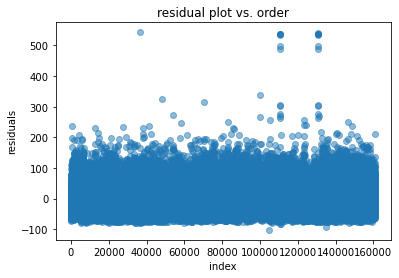

In [117]:
# residuals versus order
plt.scatter(range(len(X)), multi_full_resids, alpha=0.5)
plt.xlabel("index")
plt.ylabel("residuals")
plt.title("residual plot vs. order")
plt.show()

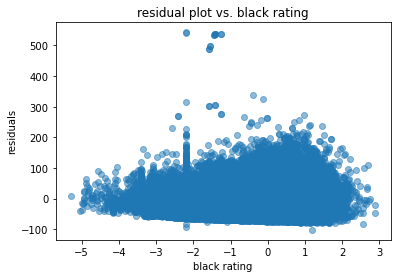

In [118]:
#residual plot vs black rating
plt.scatter(X[:, -2], multi_full_resids, alpha=0.5)
plt.xlabel("black rating")
plt.ylabel("residuals")
plt.title("residual plot vs. black rating")
plt.show()

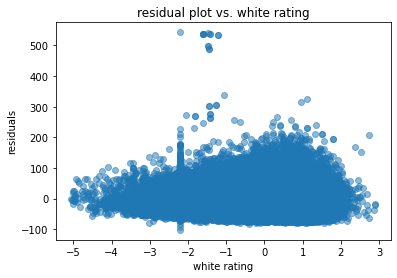

In [119]:
#residual plot vs white rating
plt.scatter(X[:, -3], multi_full_resids, alpha=0.5)
plt.xlabel("white rating")
plt.ylabel("residuals")
plt.title("residual plot vs. white rating")
plt.show()

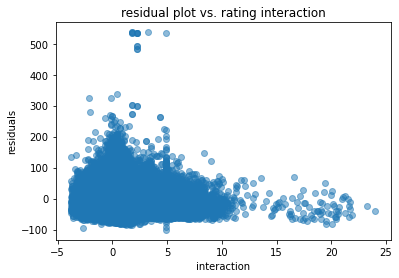

In [120]:
#residual plot vs rating interaction
plt.scatter(X[:, -1], full_resids, alpha=0.5)
plt.xlabel("interaction")
plt.ylabel("residuals")
plt.title("residual plot vs. rating interaction")
plt.show()

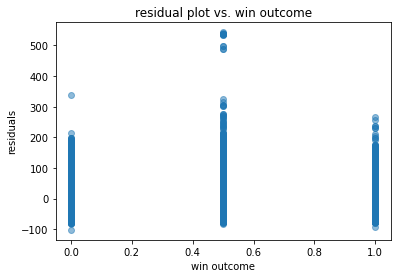

In [121]:
#residual plot vs win outcome
plt.scatter(X[:, 0], multi_full_resids, alpha=0.5)
plt.xlabel("win outcome")
plt.ylabel("residuals")
plt.title("residual plot vs. win outcome")
plt.show()

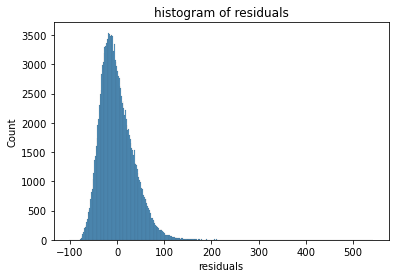

In [122]:
# histogram of residuals
sns.histplot(multi_full_resids, kde=False)
plt.xlabel("residuals")
plt.title("histogram of residuals")
plt.show()

### Step 9: Try the model with square root and logarithmic transformations of the dependent variable, based on the recommendation of the professor ###

#### Implement the model with square root transformation ####

In [123]:
# perform the square root transformation
sqrt_y = np.sqrt(y)

# build the cross validated model using the transformed y array
sqrt_cross_val = cross_validation(X, sqrt_y, 0.7, 3)

# back transform (equalize scale of) cv model ypreds and y_test (used as y for cv model) by squaring them
cv_sq_sqrt = sqrt_cross_val[0]['ypreds']**2
cv_test_sq = sqrt_cross_val[2]**2

# calculate mse using the rescaled ypreds (note that we use y_test for the original)
cv_o_scale_sqrt = np.mean((cv_test_sq-cv_sq_sqrt)**2)

# build the full model using the transformed y array
full_sqrt = full_linreg(X, sqrt_y)
full_sqrt_r2 = full_sqrt[1]
full_sqrt_resids = full_sqrt[2]
full_sqrt_coeffs = full_sqrt[3]
full_sqrt_ypred = full_sqrt[4]

# back transform (equalize scale of) full model ypreds by squaring them
sqrt_pred_back = full_sqrt_ypred**2

# calculate mse using the rescaled ypreds
sqrt_mse_original_scale = np.mean((y-sqrt_pred_back)**2)

# print results
print(f'Full MSE (original scale): {sqrt_mse_original_scale}')
print(f'Full R^2: {full_sqrt_r2}')
print(f'Cross validated MSE (original scale): {cv_o_scale_sqrt}')
print(f'Cross validated R^2: {cv_sqrt_r2}')

Full MSE (original scale): 1273.2145503596778
Full R^2: 0.11390591768035696
Cross validated MSE (original scale): 1271.8238122491607
Cross validated R^2: 0.10629760940589772


#### Check assumptions ####

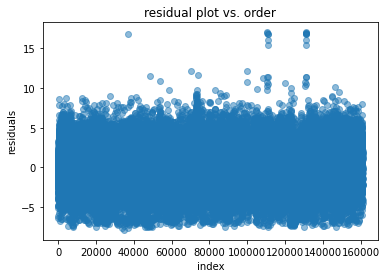

In [124]:
# residuals versus order
plt.scatter(range(len(X)), full_sqrt_resids, alpha=0.5)
plt.xlabel("index")
plt.ylabel("residuals")
plt.title("residual plot vs. order")
plt.show()

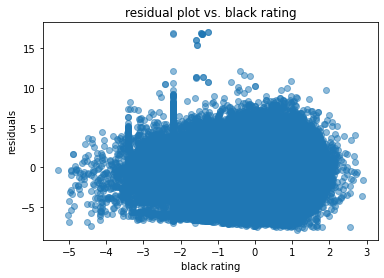

In [125]:
#residual plot vs black rating
plt.scatter(X[:, -2], full_sqrt_resids, alpha=0.5)
plt.xlabel("black rating")
plt.ylabel("residuals")
plt.title("residual plot vs. black rating")
plt.show()

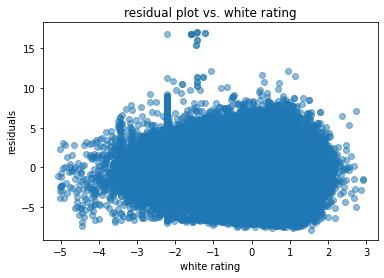

In [126]:
#residual plot vs white rating
plt.scatter(X[:, -3], full_sqrt_resids, alpha=0.5)
plt.xlabel("white rating")
plt.ylabel("residuals")
plt.title("residual plot vs. white rating")
plt.show()

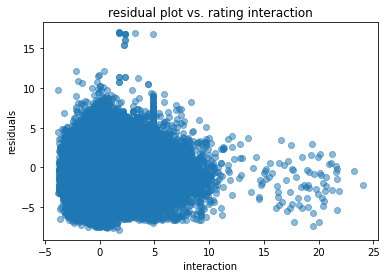

In [127]:
#residual plot vs rating interaction
plt.scatter(X[:, -1], full_sqrt_resids, alpha=0.5)
plt.xlabel("interaction")
plt.ylabel("residuals")
plt.title("residual plot vs. rating interaction")
plt.show()

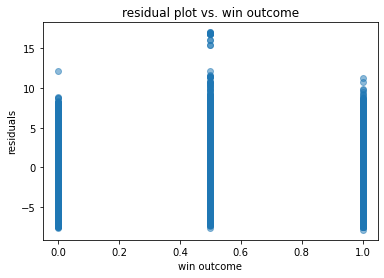

In [128]:
#residual plot vs win outcome
plt.scatter(X[:, 0], full_sqrt_resids, alpha=0.5)
plt.xlabel("win outcome")
plt.ylabel("residuals")
plt.title("residual plot vs. win outcome")
plt.show()

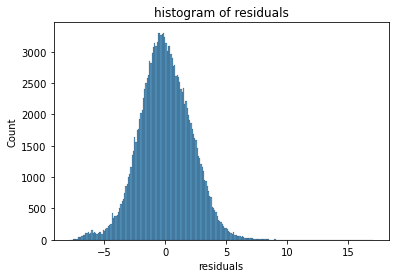

In [129]:
# histogram of residuals
sns.histplot(full_sqrt_resids, kde=False)
plt.xlabel("residuals")
plt.title("histogram of residuals")
plt.show()

#### Implement the model with the logarithmic transformation ####

In [130]:
# build the dummy variable columns from the original dataframe, dropping the first for a reference variable
df_new = pd.get_dummies(data, columns = ['opening_name'], drop_first = True)
df_new = df_new.dropna()
bool_no_zero = df_new['moves'] != 0
df_bool = df_new.loc[bool_no_zero, :]
df_no_zero = df_bool.dropna()

# standardize the black ratings and white ratings
for feat in ['white_rating', 'black_rating']:
    df_no_zero[f'{feat}_scaled'] = (df_no_zero[feat] - df_no_zero[feat].mean()) / df_no_zero[feat].std()
    
# drop all the columns that aren't relevant (x features) to this regression
new_reg_df = df_no_zero.drop(columns = ['game_id', 'white', 'white_rating', 'black', 'black_rating', 'winner', 'link', 'rating_diff', 'rating_diff_bin', 'moves'], axis = 1)

new_reg_df['rating_interaction'] = new_reg_df.white_rating_scaled * new_reg_df.black_rating_scaled

new_reg_df

,win_outcome,opening_name_Amar Opening,opening_name_Amazon Attack,opening_name_Anderssen's Opening,opening_name_Australian Defense,opening_name_Barnes Defense,opening_name_Barnes Opening,opening_name_Benko Gambit,opening_name_Benko Gambit Accepted,opening_name_Benko Gambit Declined,...,opening_name_Vulture Defense,opening_name_Wade Defense,opening_name_Ware Defense,opening_name_Ware Opening,opening_name_Yusupov-Rubinstein System,opening_name_Zukertort Defense,opening_name_Zukertort Opening,white_rating_scaled,black_rating_scaled,rating_interaction
0,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-1.537478,1.472661,-2.264184
1,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.457037,0.274774,0.400356
2,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-0.038248,1.441343,-0.055129
3,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.441255,-0.962259,-1.386861
5,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-0.081647,1.421770,-0.116083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164584,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-2.890731,-2.214951,6.402828
164585,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-2.239749,-2.860870,6.407633
164586,0.5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-0.026412,-2.860870,0.075562
164587,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-2.890731,-0.018826,0.054420


In [142]:
# rebuild the X and y arrays using the x values from the updated reg_df and the logged y values from the original data
X_new = new_reg_df.values
y_new = df_no_zero['moves'].values
y_log = np.log(y_new)

In [143]:
# implement the model on the full dataset with the logged y
full_log_ = full_linreg(X_new, y_log)

# store key model outputs
full_log_r2_ = full_log_[1]
full_log_resids_ = full_log_[2]
full_log_coeffs = full_log_[3]
full_log_ypred = full_log_[4]

# back transform full model ypreds and calculate mse on the original scale
log_pred_back = np.exp(full_log_ypred)
log_full_o_scale = np.mean((y_new-log_pred_back)**2)

# implement cross validation with the logged y
log_cross_val = cross_validation(X_new, y_log, 0.75, 4)

# store key output
log_cv_r2 = log_cross_val[0]['r2']

# back transform cv model ypreds and y_test (used as y for cv model), calculate mse
cv_exp = np.exp(log_cross_val[0]['ypreds'])
cv_test_exp = np.exp(log_cross_val[2])
log_cv_o_scale = np.mean((cv_test_exp-cv_exp)**2)

# print results
print(f'Full MSE (original scale): {log_full_o_scale}')
print(f'Full R^2: {full_log_r2_}')
print(f'Cross validated MSE (original scale): {log_cv_o_scale}')
print(f'Cross validated R^2: {log_cv_r2}')

Full MSE (original scale): 1361.7094814933487
Full R^2: 0.09774854578188419
Cross validated MSE (original scale): 1365.5553542643088
Cross validated R^2: 0.09609677836515074


#### Check assumptions ####

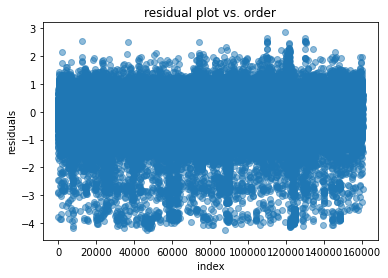

In [144]:
# residuals versus order
plt.scatter(range(len(X_new)), full_log_resids_, alpha=0.5)
plt.xlabel("index")
plt.ylabel("residuals")
plt.title("residual plot vs. order")
plt.show()

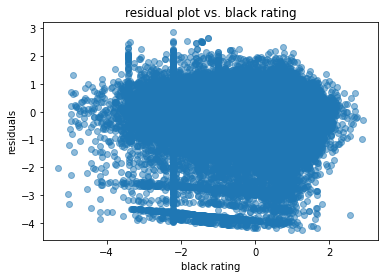

In [145]:
#residual plot vs black rating
plt.scatter(X_new[:, -2], full_log_resids_, alpha=0.5)
plt.xlabel("black rating")
plt.ylabel("residuals")
plt.title("residual plot vs. black rating")
plt.show()

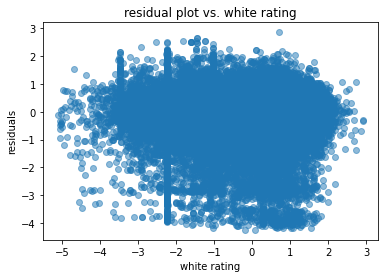

In [146]:
#residual plot vs white rating
plt.scatter(X_new[:, -3], full_log_resids_, alpha=0.5)
plt.xlabel("white rating")
plt.ylabel("residuals")
plt.title("residual plot vs. white rating")
plt.show()

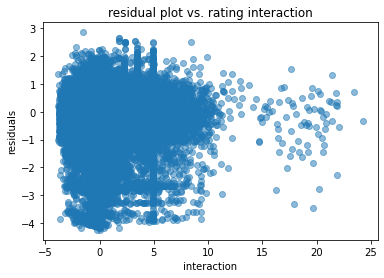

In [147]:
#residual plot vs rating interaction
plt.scatter(X_new[:, -1], full_log_resids_, alpha=0.5)
plt.xlabel("interaction")
plt.ylabel("residuals")
plt.title("residual plot vs. rating interaction")
plt.show()

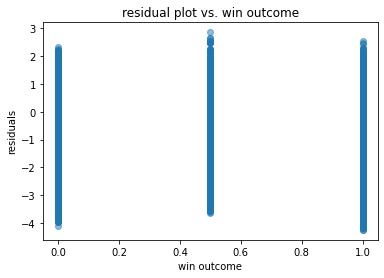

In [148]:
#residual plot vs win outcome
plt.scatter(X_new[:, 0], full_log_resids_, alpha=0.5)
plt.xlabel("win outcome")
plt.ylabel("residuals")
plt.title("residual plot vs. win outcome")
plt.show()

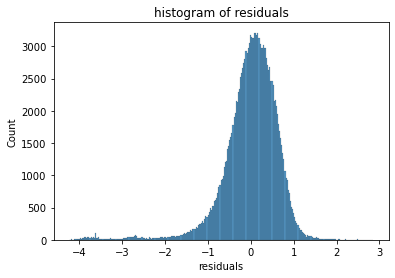

In [149]:
# histogram of residuals
sns.histplot(full_log_resids_, kde=False)
plt.xlabel("residuals")
plt.title("histogram of residuals")
plt.show()

### Step 9: Generate results tables ###

In [127]:
original_results = {'Metric': ['Cross validated R^2', 'Full model R^2', 'Cross validated MSE', 
           'Full model MSE'], 'Value': [multi_r2, full_r2, multi_mse, full_mse]}

result_frame = pd.DataFrame(original_results)

result_frame

,Metric,Value
0,Cross validated R^2,0.064121
1,Full model R^2,0.067774
2,Cross validated MSE,1247.827118
3,Full model MSE,1250.291722


In [153]:
sqrt_results = {'Metric': ['Cross validated R^2', 'Full model R^2', 'Cross validated MSE (original scale)', 
                           'Full model MSE (original scale)'], 'Value': [cv_sqrt_r2, full_sqrt_r2, cv_o_scale_sqrt, sqrt_mse_original_scale]}

sqrt_frame = pd.DataFrame(sqrt_results)

sqrt_frame

,Metric,Value
0,Cross validated R^2,0.106298
1,Full model R^2,0.113906
2,Cross validated MSE (original scale),1271.823812
3,Full model MSE (original scale),1273.214550


In [154]:
log_results = {'Metric': ['Cross validated R^2', 'Full model R^2', 'Cross validated MSE (original scale)', 
                           'Full model MSE (original scale)'], 'Value': [log_cv_r2, full_log_r2_, log_cv_o_scale, log_full_o_scale]}

log_frame = pd.DataFrame(log_results)

log_frame

,Metric,Value
0,Cross validated R^2,0.096097
1,Full model R^2,0.097749
2,Cross validated MSE (original scale),1365.555354
3,Full model MSE (original scale),1361.709481


### Step 10: Final Discussion and reflections ###
The model with the interaction term is marginally improved from the original model. We saw about a 12% improvement in the cross validated R^2 score, from about 0.057 to about 0.064. This is a nontrivial improvement, but unfortunately it really doesn't make the model much more useful. Its predictive power remains limited, and it still explains less than 6.5% of the variation in the move count. Additionally, the issues with the model's assumptions likely persist in the slightly improved version, as we have not taken steps to transform the data yet. The new feature (an interaction between the white rating and black rating variables) also appears to have a pattern when plotted against the model's residuals, with the residuals getting smaller as the interaction term increases. This suggests that the model's assumptions are still in doubt and require some work to fix. It is also possible that this model is simply ill-equipped to predict the move count. We will explore this further in the final report.  

# Fourth ML Model: First Perceptron #
This is our preliminary implementation of the perceptron, as referenced earlier in the Phase III report. We plan to finalize it for the final report. 

### Step 1: Preliminaries (imports and data cleaning) ###

In [ ]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

In [ ]:
# Filter only the clear winners.
clear_games = data[data['win_outcome'] != 0.5].copy()

### Step 2: Implement the model programmatically using Sci-Kit Learn ###

In [ ]:
# input/output for perceptron
X_perc = clear_games['rating_diff'].values.reshape(-1, 1)
y_perc = (clear_games['win_outcome'] == 1).astype(int)  # white win = 1, black = 0

clf = Perceptron(random_state=42)  # train model
clf.fit(X_perc, y_perc)

# boundary points for visual
X_boundary = np.linspace(X_perc.min(), X_perc.max(), 100).reshape(-1, 1)
y_boundary = clf.predict(X_boundary)  

y_pred = clf.predict(X_perc)  # preds for data
misclassified = y_pred != y_perc  # misclassify info

accuracy = accuracy_score(y_perc, y_pred)  # model acc
print(f"The model's accuracy score is about {accuracy*100}%")

### Step 3: Build a perceptron plot to display our result ###

In [ ]:
# scatter points
plt.figure(figsize=(12, 6))
plt.scatter(X_perc[~misclassified], y_perc[~misclassified], c='green', alpha=0.5, label='Correct')  # correct
plt.scatter(X_perc[misclassified], y_perc[misclassified], c='red', alpha=0.5, label='Incorrect')  # wrong

plt.plot(X_boundary, y_boundary, 'b-', label='Boundary')  # decision line
plt.title('Outcome Perceptron')
plt.xlabel('Rating Diff (W - B)')
plt.ylabel('Outcome (1=W, 0=B)')
plt.legend()
plt.grid(True, alpha=0.3)

accuracy = accuracy_score(y_perc, y_pred)  # model acc
plt.text(0.02, 0.98, f'Acc: {accuracy:.5f}', transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.show()

### Step 4: Discussion and reflections ###
The model seems strong. It achieves a classification accuracy of about 72.76%, a reasonably high score for a model like this. Based on our plot, the perceptron seems to be working well and as expected. We use rating differential to predict the game outcome, as referenced above. The perceptron creates a clearer, more specific, and more robust means of win outcome prediction than the more rudimentary linear regression win rate predictor we created previously. However, before we can finalize the model, we need to implement cross validation to ensure that our outcome is useful. Overall, this seems like an excellent start that has the potential to yield a meaningful and impactful ML model for predicting chess outcomes based on the difference between the Lichess ratings of the two players. 

In [ ]:
from sklearn.linear_model import SGDClassifier
import plotly.express as px
# y = win outcome column
y = np.array(clear_games['win_outcome'])
x1 = np.array(clear_games['rating_diff']) # white - black
x2 = np.array(clear_games['moves']) 
X = np.concatenate([np.ones(len(x1)).reshape(-1,1), 
                    x1.reshape(-1,1), 
                    x2.reshape(-1,1)], axis = 1)

In [ ]:
def perceptron(X, y, lossfn):
    ''' Performs perceptron algorithm for given dataset and loss function
    
    Args
        X (array): array with bias term and x features
        y (array): array of categorical outcome as 0s or 1s
        lossfn (string): loss function for perceptron algorithm

    Returns
        fin_w (array): array of perceptron coefficients 
        lineq (string): string for final line using fin_w
    '''
    perceptron = SGDClassifier(loss=lossfn, max_iter=1500, random_state=42, fit_intercept = True, alpha = .01, shuffle = False)

    # fitting training data
    perceptron.fit(X, y)
    
    # final w vector (intercept, x1 coefficient, x2 coefficient)
    fin_w = perceptron.coef_[0]

    # final line x2 = intercept + x1
    lineq = f"x_2 = {-(fin_w[0]/fin_w[2]).round(2)} + {-(fin_w[1]/fin_w[2]).round(2)}x_1"
    return fin_w, lineq

In [ ]:
def perc_accuracy(X, y, w):
    ''' calculates accuracy for linear (hinge loss) perceptron
    Args
        X (array): array with bias term and x features
        y (array): array of categorical outcome as 0s or 1s
        w (array): array of perceptron coefficients
        
    Returns
        accuracy (float): perceptron accuracy
    '''
    #predicting outcomes
    yhat = np.where(np.dot(X, w) >= 0, 1, -1)
    
    #counting number correctly predicted (yhat) compared to actual (y
    correct = 0
    for i in range(len(y)):
        if y[i] == yhat[i]:
            correct += 1
    
    #calculating accuracy
    accuracy = correct/len(y)
    
    return accuracy

In [ ]:
#split up full dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.7)
hinge_train = perceptron(X_train, y_train, "hinge")
train_w = hinge_train[0]
print(train_w)
print(f'The final line is: {hinge_train[1]}')

In [ ]:
# calculating accuracy for cross validation 
hinge_train_acc = perc_accuracy(X_test, y_test, train_w)
print(f'Linear perceptron accuracy: {round(hinge_train_acc*100,2)}%')

In [ ]:
# hinge perceptron on full data set
hinge_full = perceptron(X, y, "hinge")

# w vector for full data set
fin_w = hinge_full[0]
print(fin_w)
print(f'The final line is: {hinge[1]}')

# accuracy for full data set
hinge_acc = perc_accuracy(X, y, fin_w)
print(f'Linear perceptron accuracy: {round(accuracy*100,2)}%')

In [ ]:
# scatter plot
# px.scatter(x = x1, y = x2, color = y, title = "Match Length vs Rating Differential",  
#            labels = {"x" : "Rating Differential", "y": "Match Length (moves)", "color": "White wins"})

In [ ]:
xlim = -1, 1
fig.add_shape(type="line",
    x0=xlim[0], y0=-(fin_w[0]/fin_w[2]) - (fin_w[1]/fin_w[2])*xlim[0], 
              x1=xlim[1], y1=-(fin_w[0]/fin_w[2]) - (fin_w[1]/fin_w[2])*xlim[1],
    line=dict(
        color="MediumPurple",
        width=2,
        dash="dot",
    ))
fig.show()

In [ ]:
# pred0 being false sets 0 as the default class;
# pred0 being true sets 1 as the default class~ probabilities are likelihood of the datapoint being 1
def predict_perceptron_sigmoid(x, w, pred0 = True):
    ''' predicts probabilities for y values being 1 given x feature values and w vector
    Args
        x (array): array with bias term and x features
        w (array): array of perceptron coefficients
        pred0 (boolean): false sets default class to 0 and true sets 1
    
    Return
        yhat (array): array of probabilities
    '''
    if pred0 == True:
        yhat = 1/(1 + np.exp(np.dot(x, w)))
    else:
        yhat = np.exp(np.dot(x, w))/(1 + np.exp(np.dot(x, w)))
        # this is the same thing as
        # yhat = 1 - (1/(1 + np.exp(np.dot(x, w))))
    return yhat

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.7)

log_train = perceptron(X_train, y_train, 'log_loss')
train_w = log_train[0]
print(f'Trained w: {train_w}')
print(np.apply_along_axis(predict_perceptron_sigmoid, 1, X_test, pred0=True, w=train_w))
print(y)

In [ ]:
# in sci-kit learn
# sigmoid activation/log loss
full_log = perceptron(X, y, 'log_loss')
fin_w = full_log[0]
print(fin_w)
print(full_log[1])
yhat = np.apply_along_axis(predict_perceptron_sigmoid, 1, X, pred0=True, w= fin_w)
print(yhat[:5])
# print(y)
#0 = black wins, 1 = white wins | high probability = higher likelihood the result is 1 aka white wins

In [ ]:
yhat_predic = []
for item in yhat:
    if item > 0.50:
        item = 1
    else:
        item = 0
    yhat_predic.append(item)

correct = 0
for i in range(len(y)):
    if yhat_predic[i] == y[i]:
        correct += 1
accuracy = correct/len(y) * 100
print(accuracy)

### Discussion
The hinge loss function perceptron results indicate that rating differential has a greater impact on the match outcome compared to match length. The coefficient of the rating differential (1.3899) was 13.83 times larger in magnitude than that for match length (-0.10052) (table 3). The accuracy of the model was  36.54% (table 3). The log loss function perceptron model supported these findings. The rating differential coefficient (1.33043) was 15.06 times larger than that for match length (-0.08832) (table 4). The accuracy for the model, 27.48% (table 4), was calculated by setting outcomes of 1 for probabilities over 50% and 0 for probabilities below 50%. Fitting the line of best fit of each model to the scatterplot of data shows the line running along a part of the graph where there were mostly black wins on one side and white wins on the other (fig.8, fig.  9). The data is not perfectly linearly separable as seen by the mixing of yellow (white win) and blue (black win) datapoints on either side of the perceptron line.

Overall, both perceptron models were relatively inaccurate as shown by their less than 37% accuracies. This was expected as it would be unreasonable to expect two features to accurately predict the outcome of a chess match given its complex nature. Both models' final weight vectors indicated that a higher rating increased the probability of winning a match and longer matches increased the probability for black to win. The models also indicated that rating differential had a relatively larger influence on the game outcome compared to the match length. Future analyses using a perceptron might benefit from incorporating the opening used in each match. The playstyle of the players might be another important feature for outcome prediction. Would having a more aggressive playstyle increase a player’s chance of winning? While playstyle is not provided by the Lichess API, the API does provide the details for every move made in the game, including the captures. An ‘aggressiveness’ feature could be engineered based on, for example, the number of captures a player makes within a certain number of moves.  